### 1、下载数据集

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [4]:
def download(name, cache_dir=os.path.join('./', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

import tensorflow as tf
from d2l import tensorflow as d2l

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
#sns.set(rc={"figure.figsize":(16, 3)})  # 调整图片大小，宽 * 高

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

### 2、查看数据集大小

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载./data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载./data/kaggle_house_pred_test.csv...


In [289]:
print('The shape of training data:', train_data.shape)
train_data.head()

The shape of training data: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [290]:
print('The shape of testing data:', test_data.shape)
test_data.head()

The shape of testing data: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 3、目标值分析：分析目标值分布、其他变量与目标值的关系

<Axes: xlabel='SalePrice', ylabel='Density'>

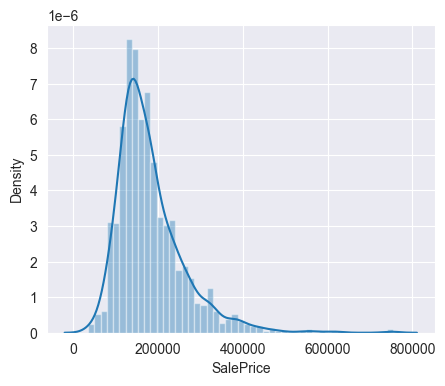

In [291]:
#绘制目标值分布
plt.figure(figsize=(5, 4))
sns.distplot(train_data['SalePrice'])

In [292]:
train_data['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

**由上图可知**：
- 目标值右偏
- 分布曲线有尖峰

In [293]:
#分离数字特征和类别特征
#num_features = test_data.dtypes[test_data.dtypes != 'object'].index
num_features = test_data.iloc[:, 1:].select_dtypes(exclude='object').columns
cate_features = test_data.dtypes[test_data.dtypes == 'object'].index

print(num_features)
print('number of numeric features:', len(num_features))
print('number of categorical features:', len(cate_features))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
number of numeric features: 36
number of categorical features: 43


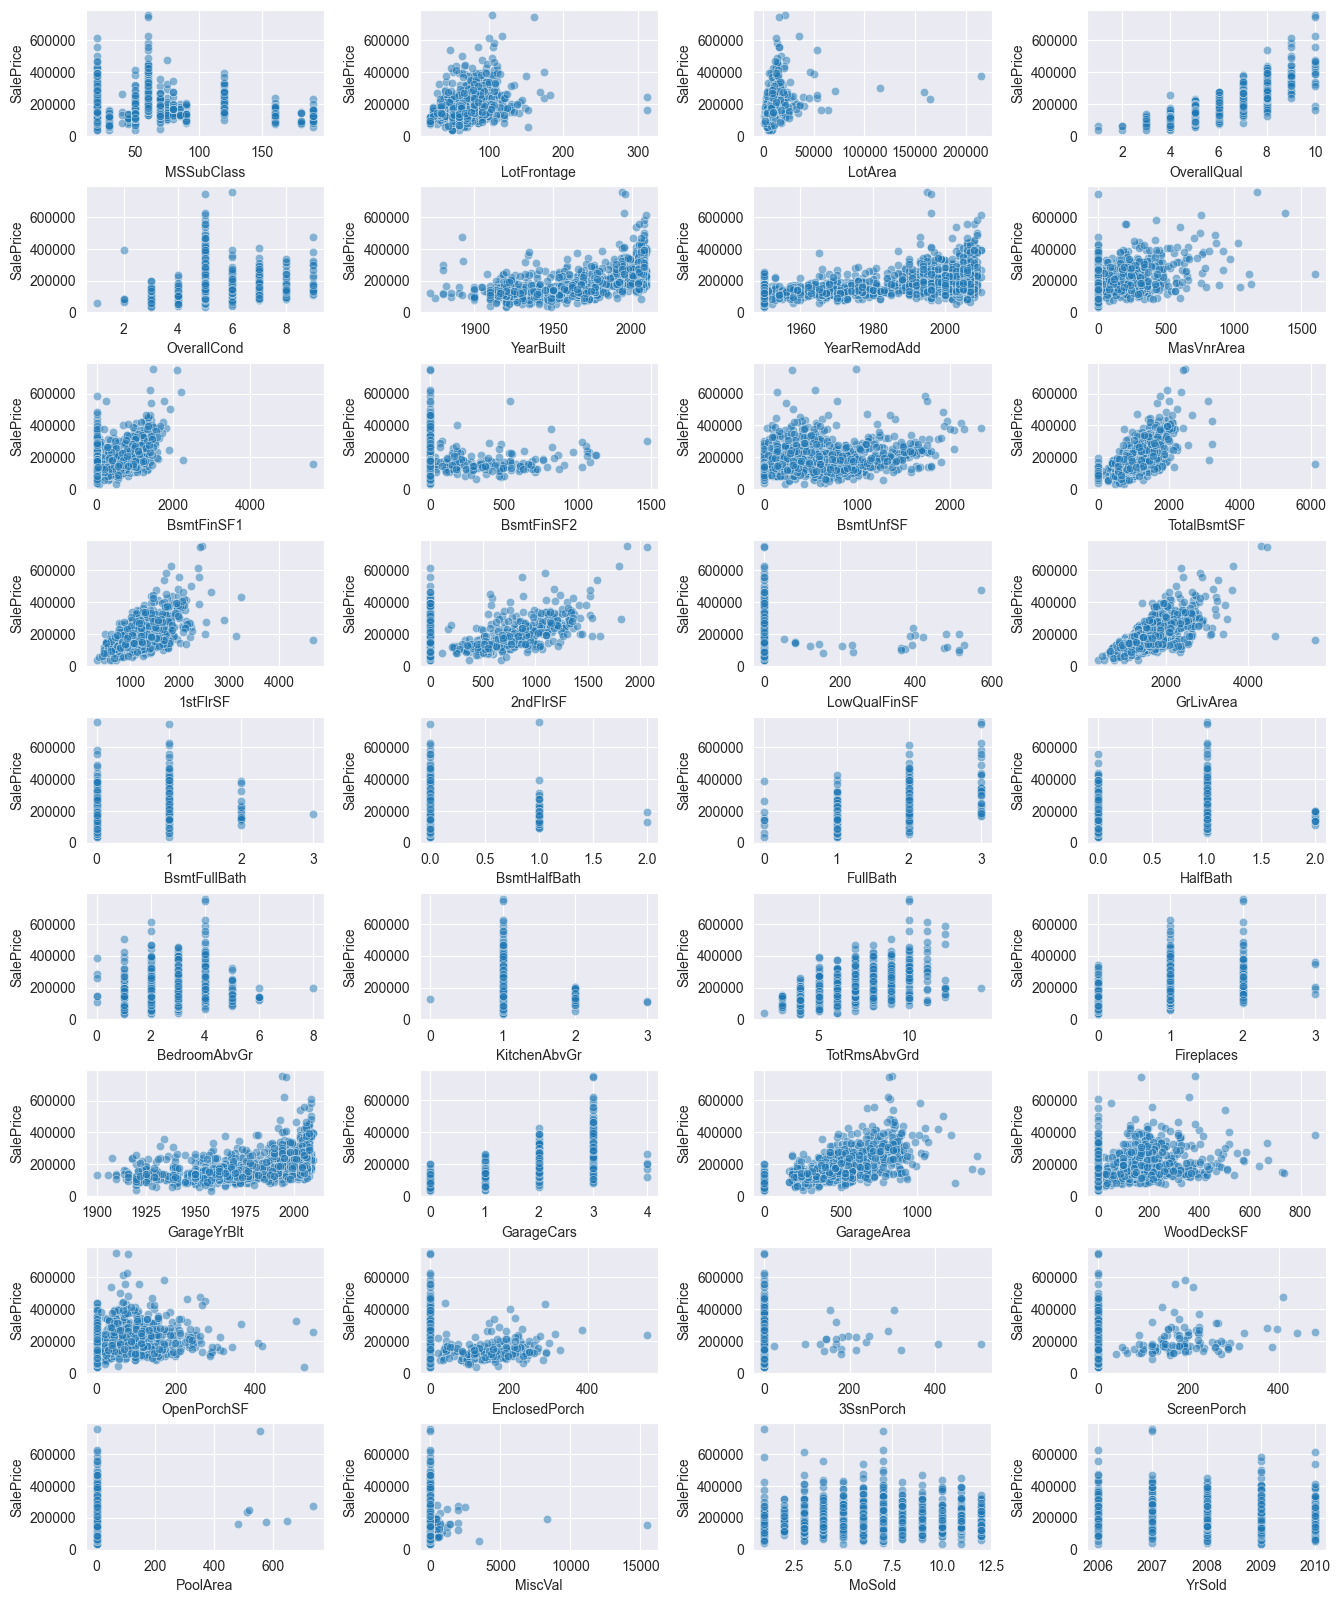

In [294]:
#查看数字特征与目标值的关系
plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(num_features):
    plt.subplot(9, 4, i + 1)
    sns.scatterplot(x=feature, y='SalePrice', data=train_data, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

**'TotalBsmtSF'、'GrLiveArea'与目标值呈明显的线性关系**

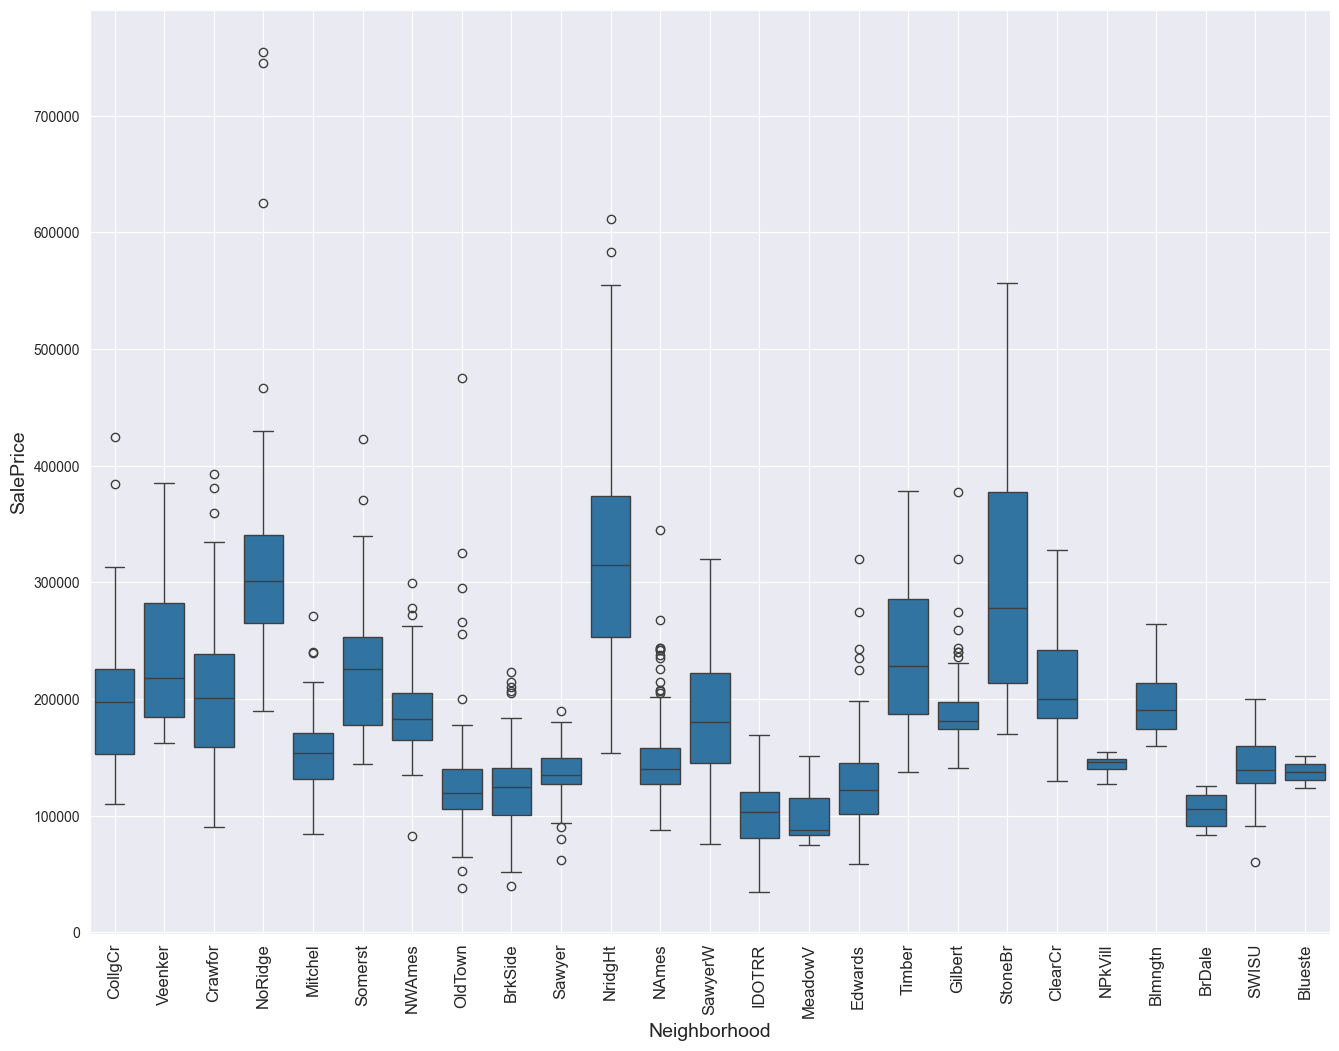

In [295]:
#查看‘Neighborhood’与目标值的关系
plt.figure(figsize=(16, 12))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_data)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(True)

**不同的邻居类型房价的分布模式不同**

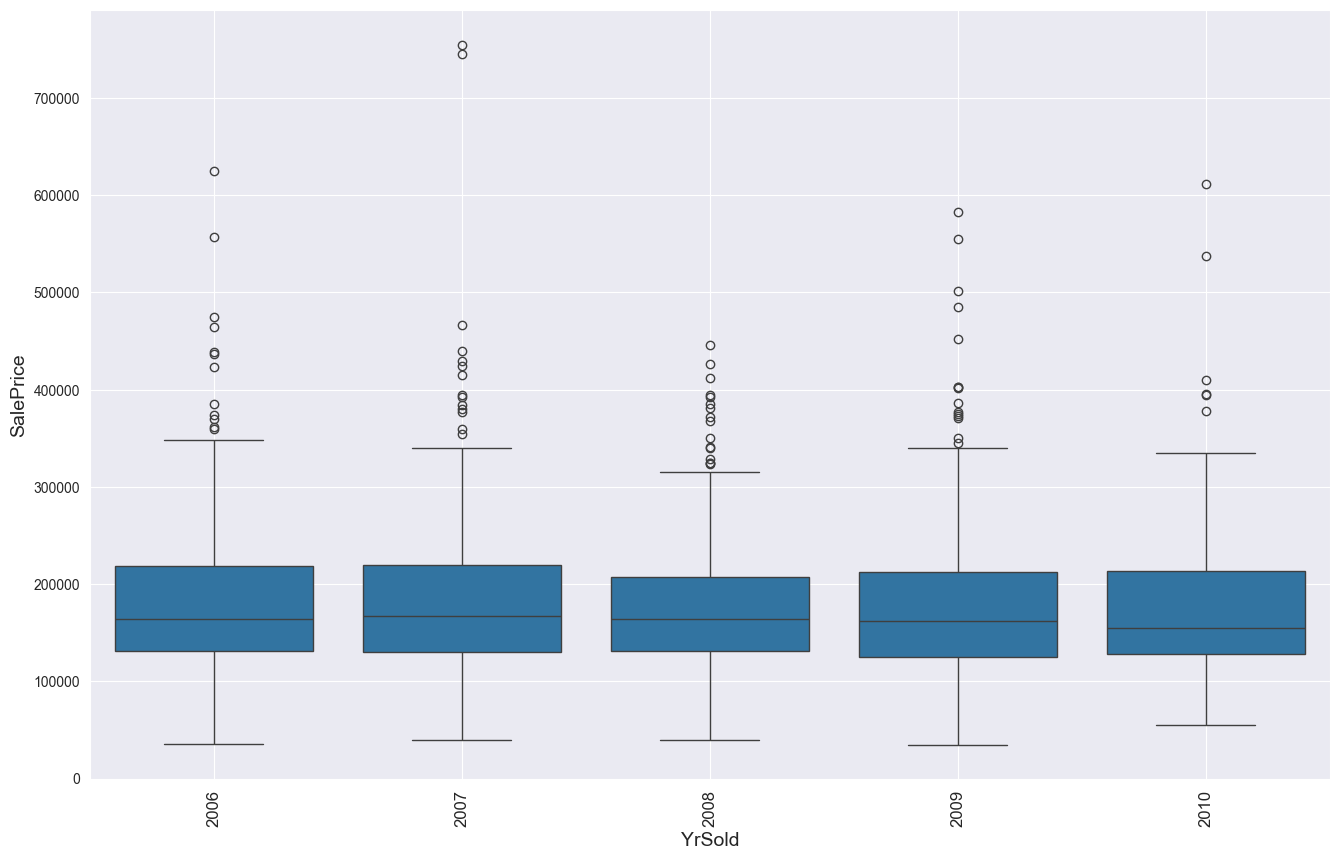

In [296]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='YrSold', y='SalePrice', data=train_data)
plt.xlabel('YrSold', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(True)

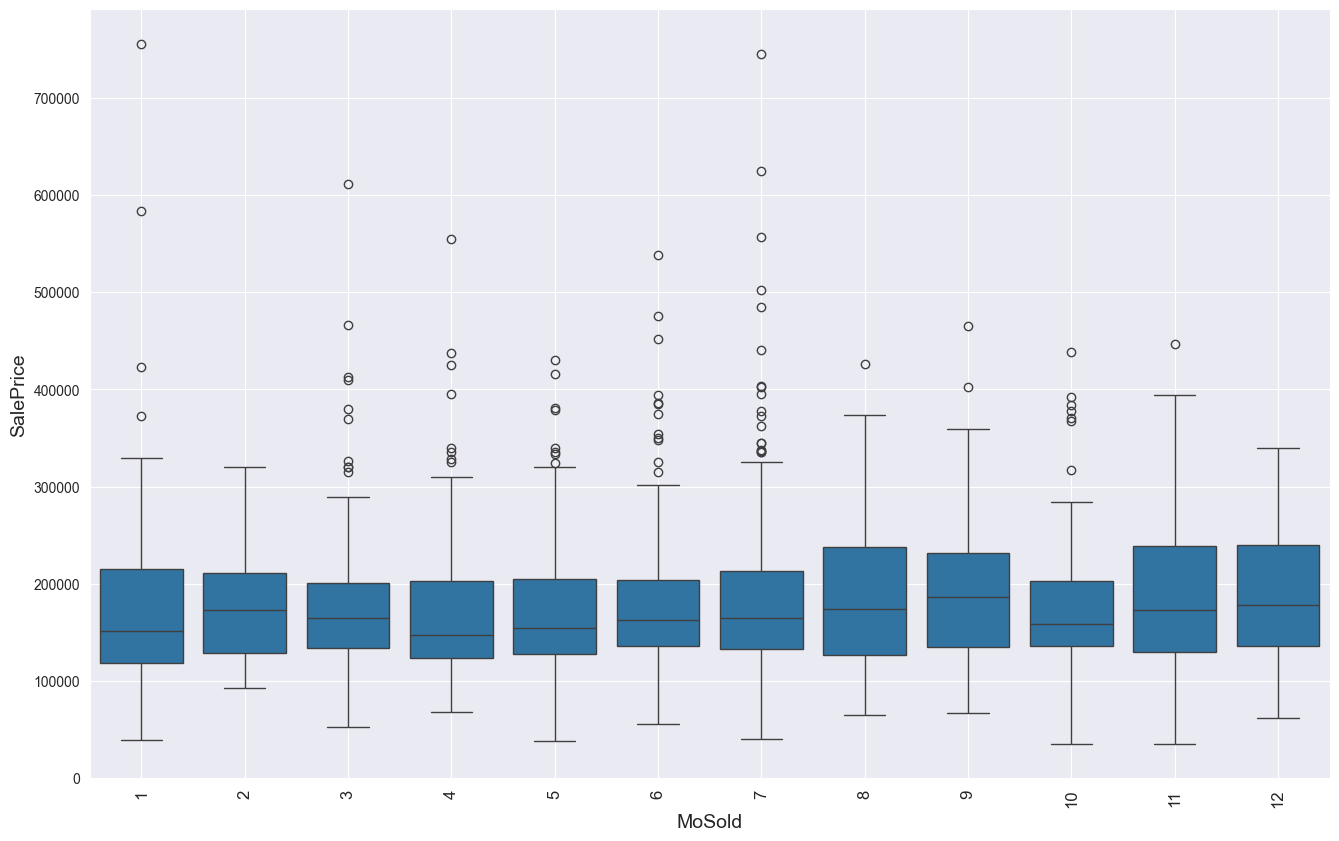

In [297]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='MoSold', y='SalePrice', data=train_data)
plt.xlabel('MoSold', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(True)

**不同年份/月份卖出的房价分布模式并没有太大的差别，可以认为该问题中房屋售价没有收到不同年份通货膨胀的影响，因此不考虑加入通胀等额外信息**

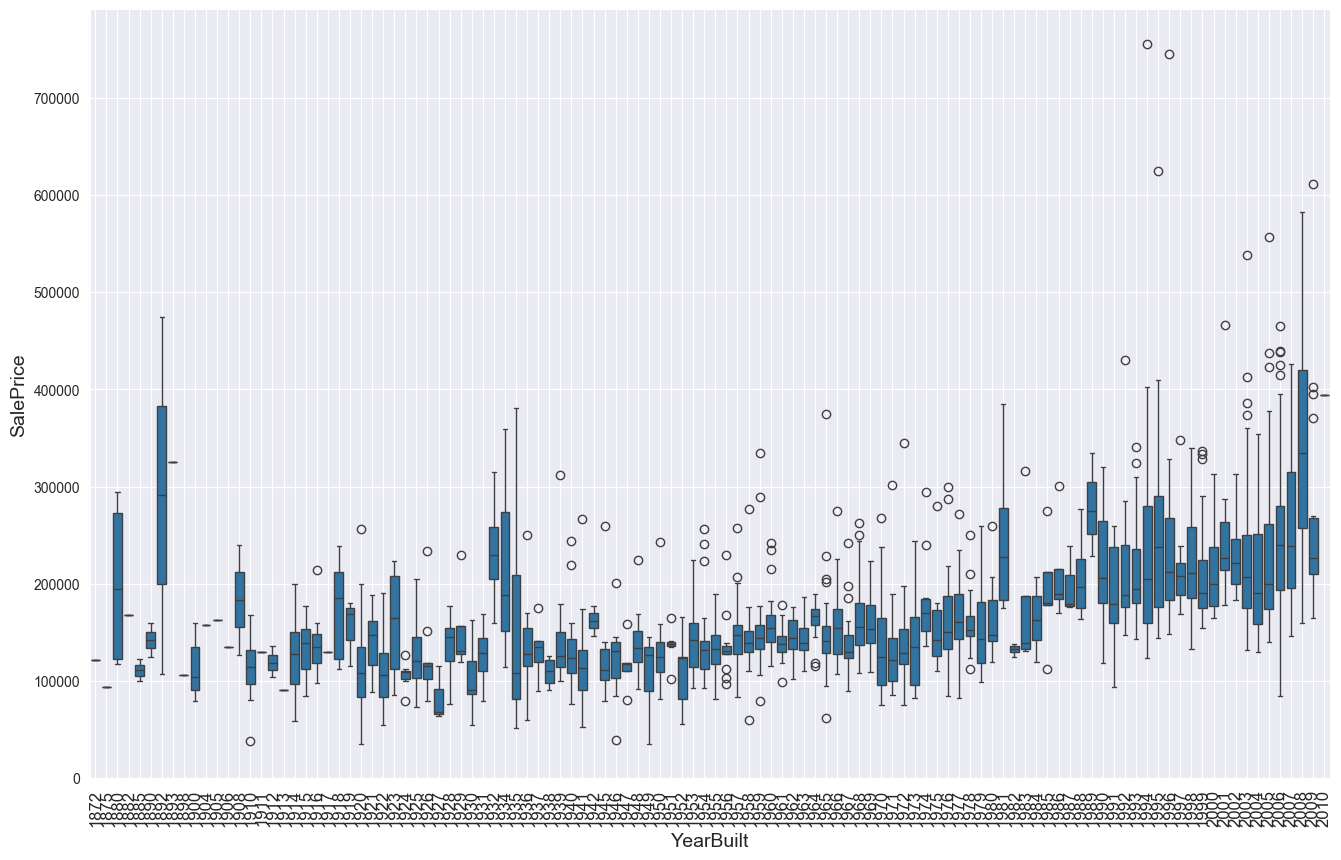

In [298]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_data)
plt.xlabel('YearBuilt', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(True)

**房屋的建造年份和 SalePrice 房价相关性不强。**

In [299]:
feats2del = set()

def add_feats2del(feat):
    feats2del.add(feat)
    print(f'feats2del:{feats2del}')

add_feats2del('Id')

feats2del:{'Id'}


In [300]:
add_feats2del('YrSold')
add_feats2del('MoSold')
add_feats2del('YearBuilt')

feats2del:{'Id', 'YrSold'}
feats2del:{'Id', 'YrSold', 'MoSold'}
feats2del:{'Id', 'YrSold', 'MoSold', 'YearBuilt'}


### 4、多变量分析：分析各变量之间的关系

<Axes: >

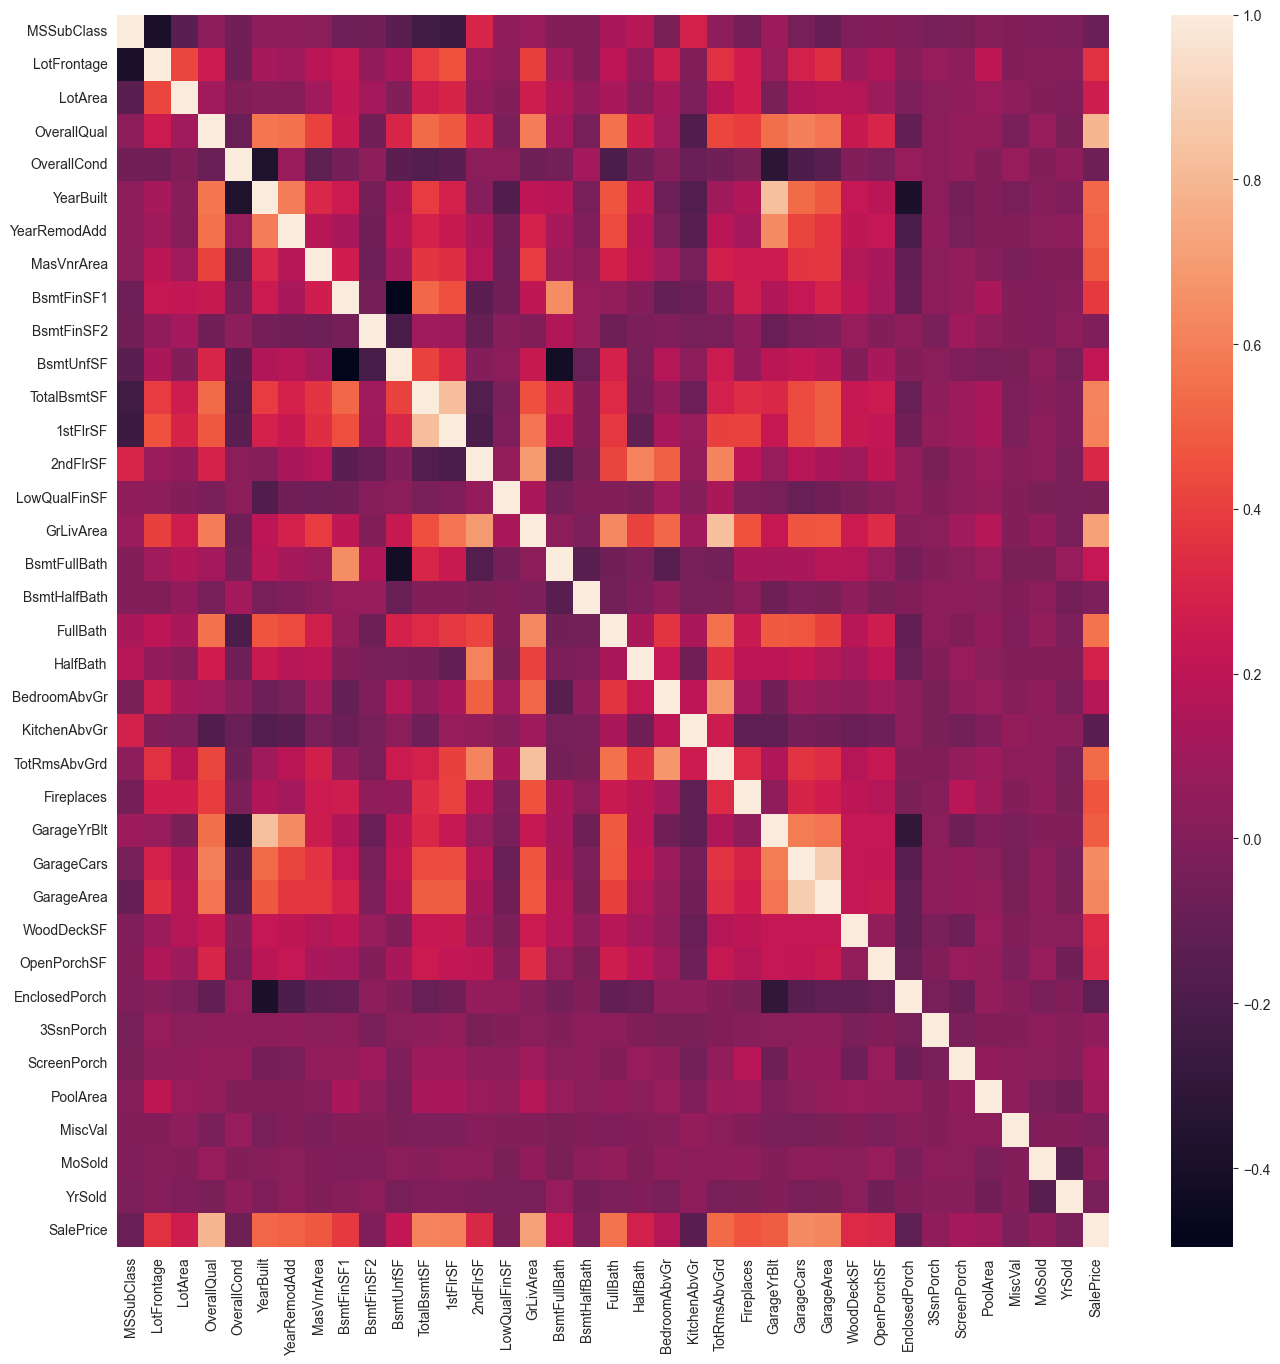

In [301]:
corrs = train_data[train_data.iloc[:, 1:].dtypes[train_data.dtypes != 'object'].index].corr()

plt.figure(figsize=(16, 16))
sns.heatmap(corrs)

**存在较明显的相关性的变量**
- 'TotalBsmtSF’和'1stFlrSF'
- 'GarageArea'和'GarageCars'

<Axes: >

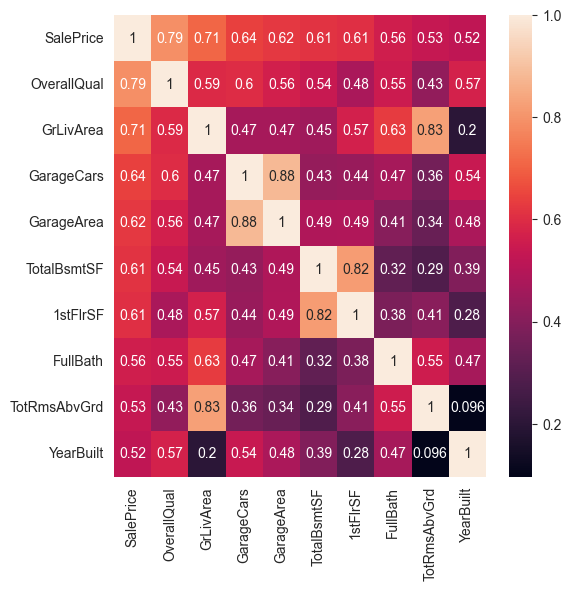

In [302]:
#分析与目标值相关度最高的十个变量
cols_10 = corrs.nlargest(10, 'SalePrice')['SalePrice'].index
corrs_10 = train_data[cols_10].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corrs_10, annot=True)

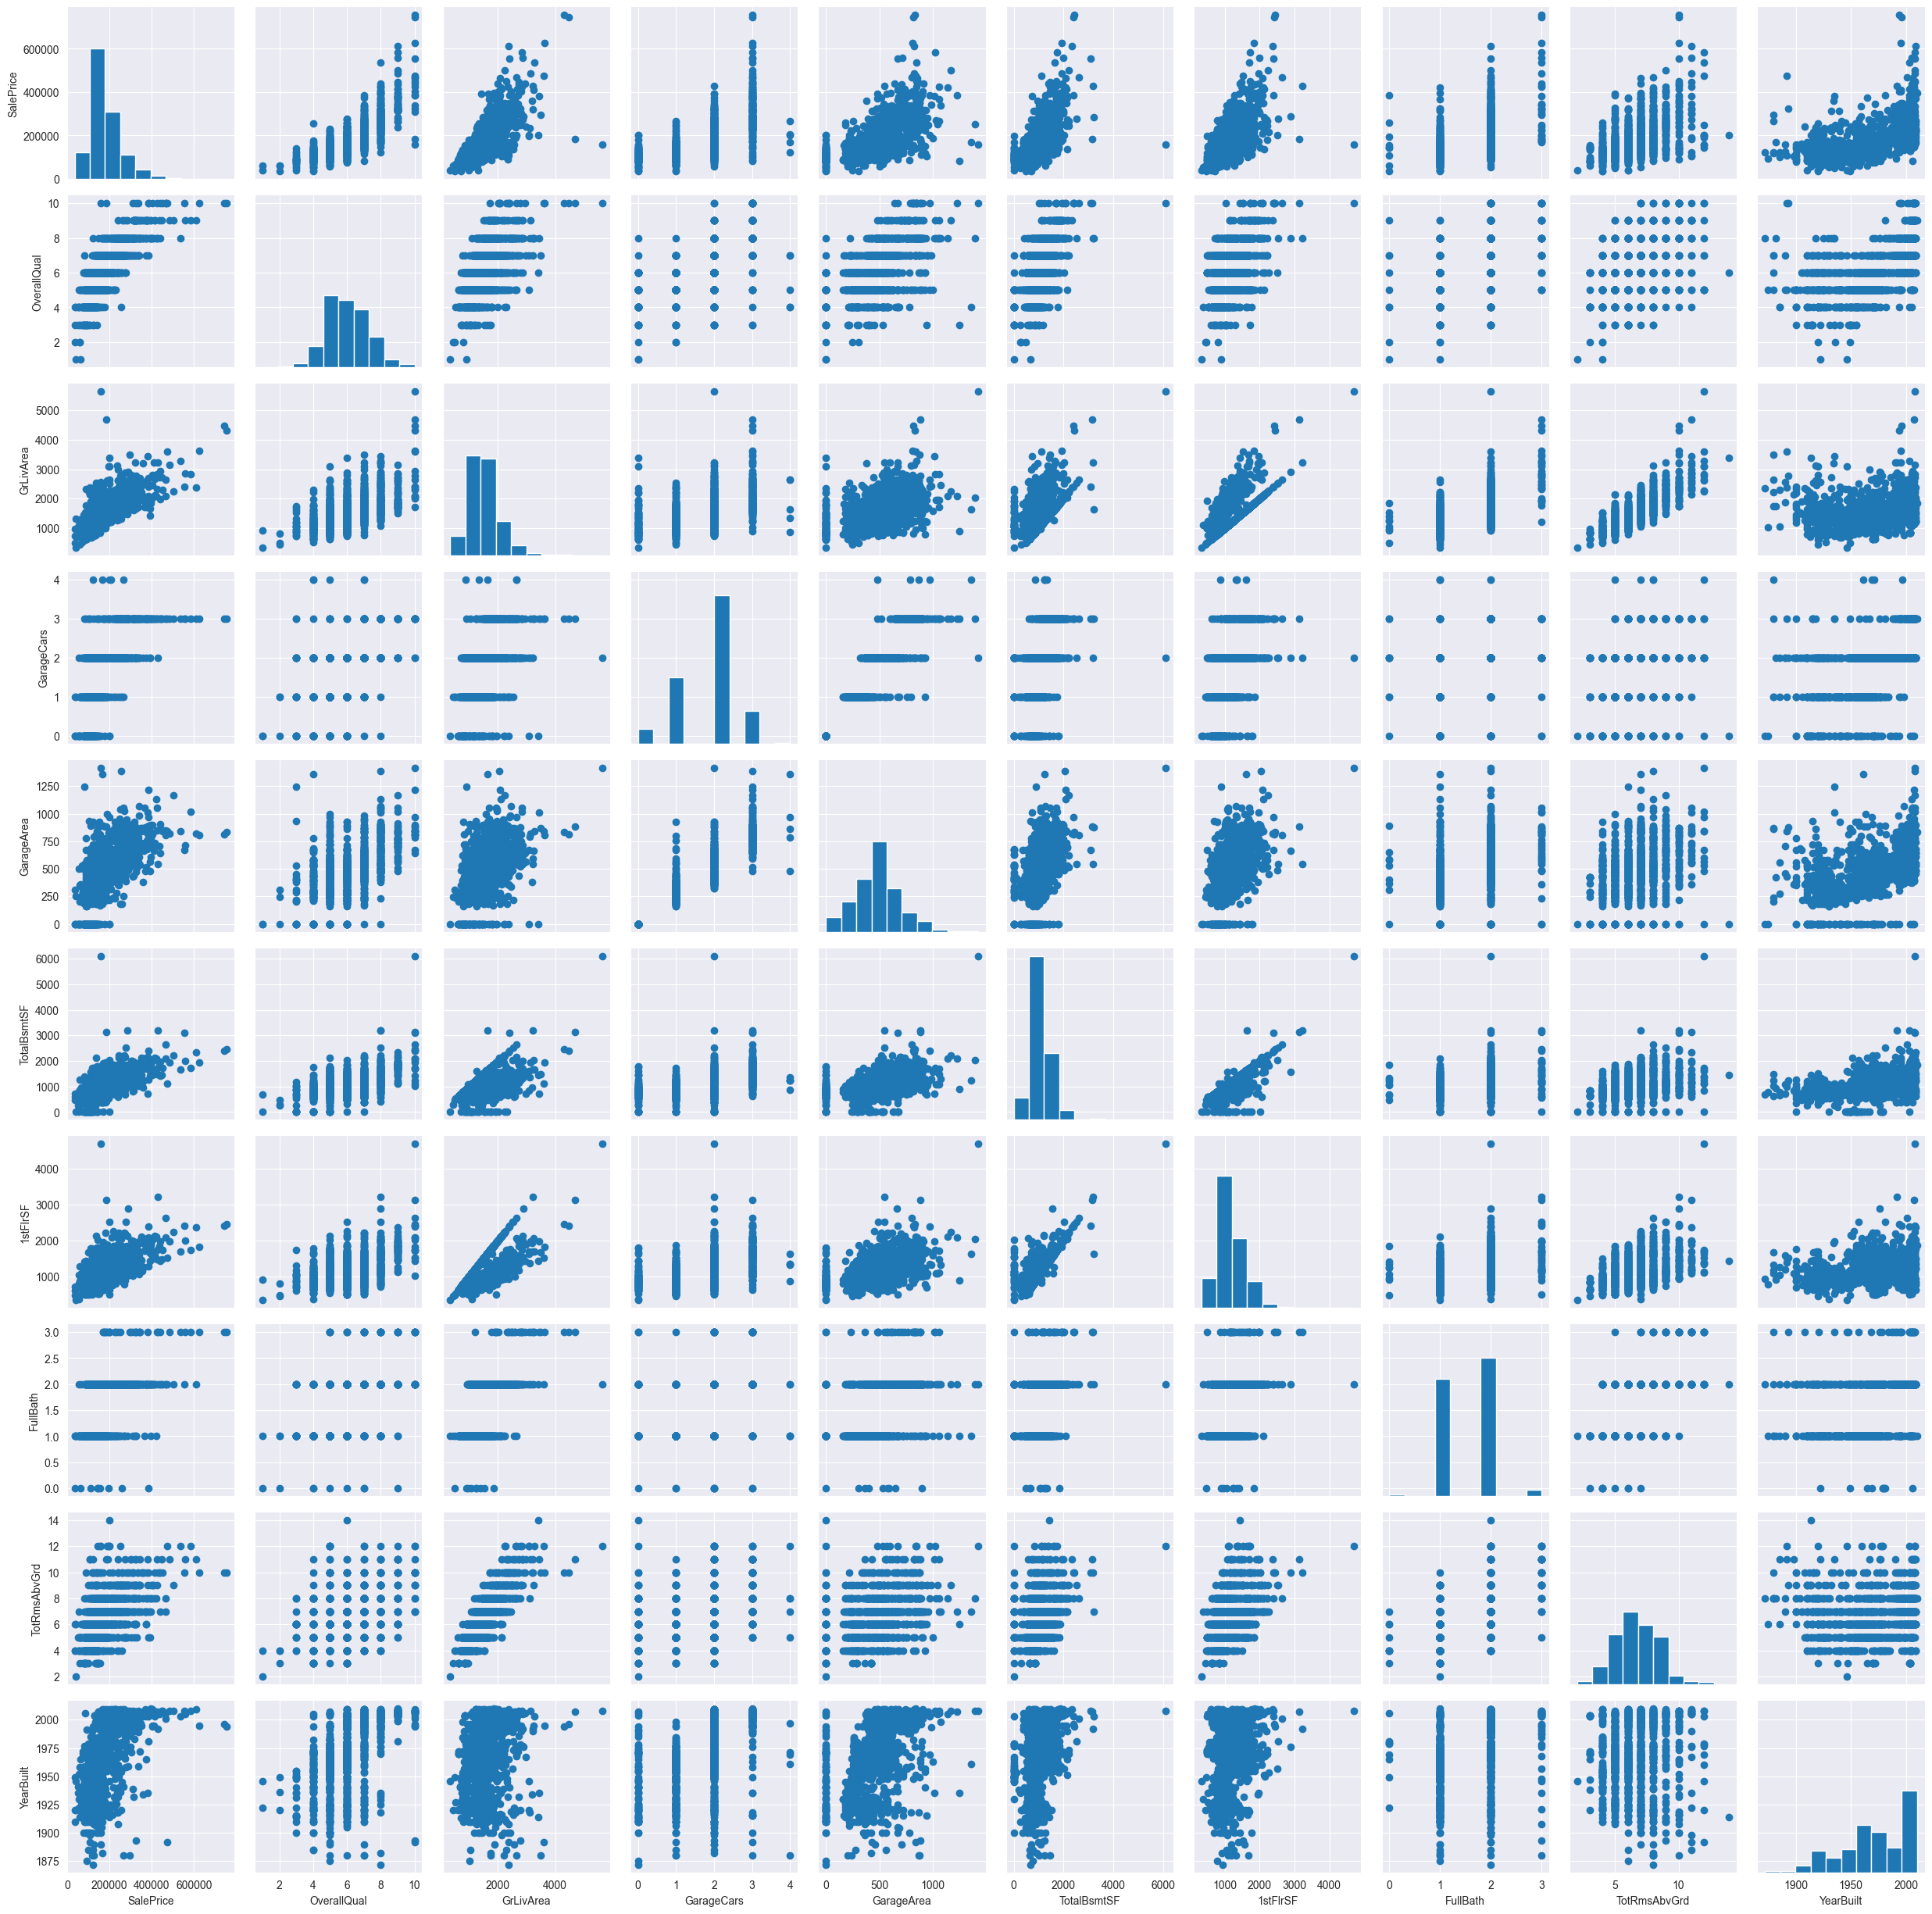

In [303]:
g = sns.PairGrid(train_data[cols_10])
g.map_diag(plt.hist)  # 对角线显示直方图
g.map_offdiag(plt.scatter)

相关性高的多个属性保留一个

- 车库面积 GarageArea 和车库车辆容量大小 GarageCar 之间相关性较强。车库车辆容量大小 GarageCar 是由车库面积 GarageArea 决定的，所以不需要专门区分 GarageCars 和 GarageAre，所以我们只需要其中的一个变量。这里我们选择了 GarageCars，因为它与 SalePrice 的相关性更高一些。
- 地下室面积 TotaLBsmtSF 与一层建筑面积 1stFlrSF 与上述情况相同，但是有些户型没有地下室，可以选择 1stFlrSF。
- FullBath 是针对 halfbath room的，full bathroom 是带淋浴的，而 half bathroom 只有洗手盆、马桶，两者的区别就是能否洗澡。
- TotRmsAbvGrd 地上房间数(不包括浴室)和 GrLivArea 地上居住面积成正相关，选择 GrLivArea。

In [304]:
add_feats2del('GarageArea')
add_feats2del('TotalBsmtSF')
add_feats2del('TotRmsAbvGrd')

feats2del:{'MoSold', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}
feats2del:{'TotalBsmtSF', 'MoSold', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}
feats2del:{'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}


### 5、异常值处理
**离群点不同于分散度，离群点指偏离趋势的点，比如某特征和房价是正相关的，在趋势轴上即时很分散，但是不可以删除的，而不在趋势轴上的“离群点”是需要删除的。**

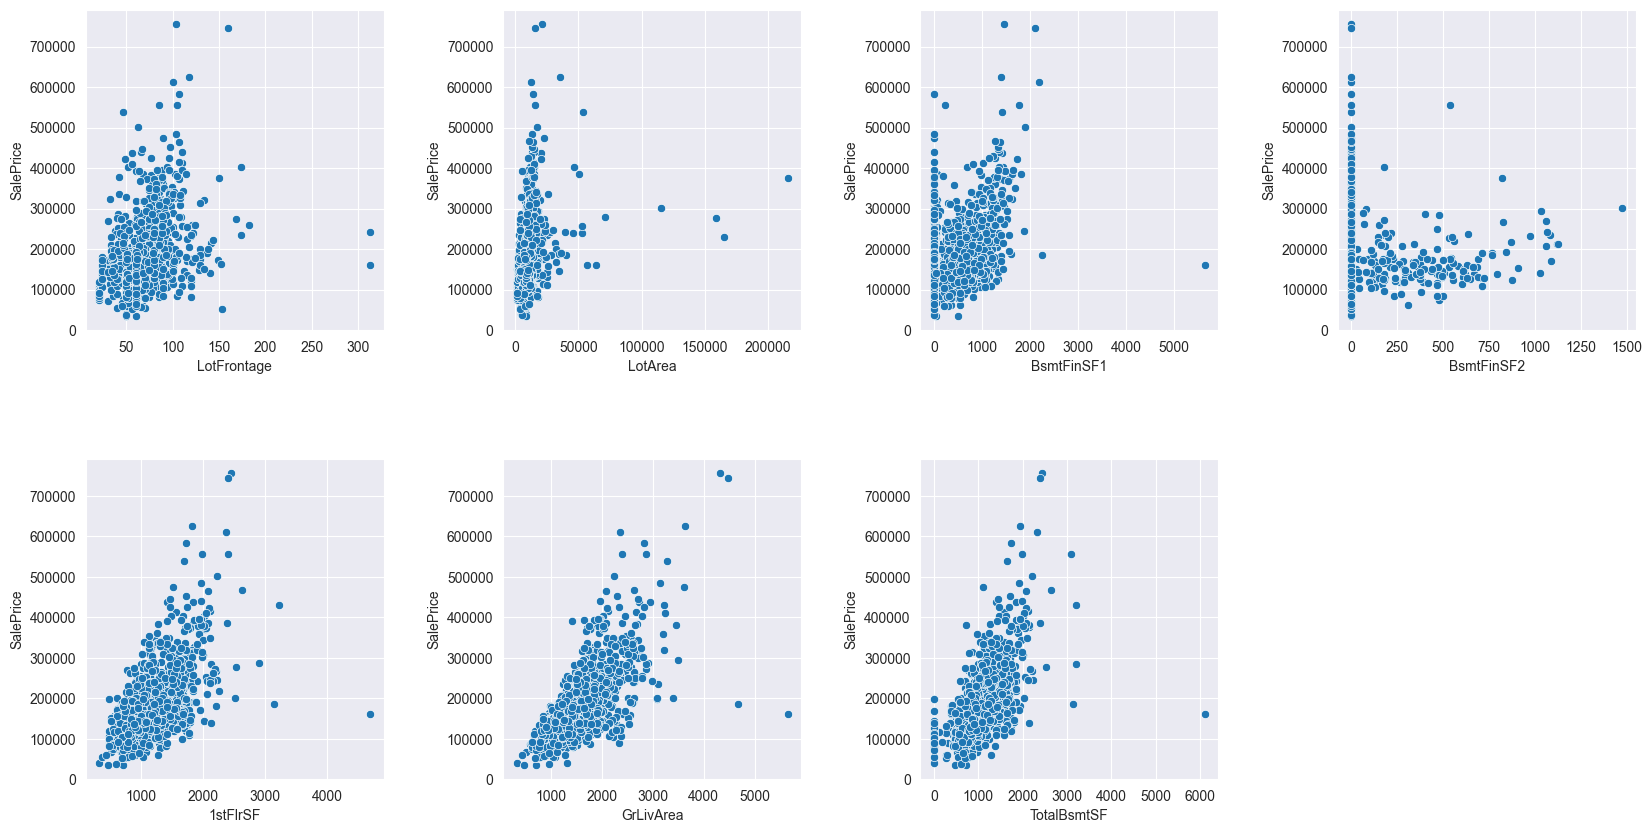

In [305]:
feats_away = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF']

#查看数字特征与目标值的关系
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(feats_away):
    plt.subplot(2, 4, i + 1)
    sns.scatterplot(x=feature, y='SalePrice', data=train_data)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

In [306]:
#处理掉右下的明显异常值
#train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index)
#plt.figure(figsize=(5, 5))
#sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_data)

#处理掉右下的异常值
#train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index)
#plt.figure(figsize=(5, 5))
#sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)

ids2del = set()

In [307]:
train_data.sort_values(by = 'LotFrontage', ascending = False)[:2][['Id', 'LotFrontage', 'SalePrice']]

,Id,LotFrontage,SalePrice
1298,1299,313.00,160000
934,935,313.00,242000


In [308]:
id2del = set()

id2del.add(1299)
id2del.add(935)

In [309]:
train_data.sort_values(by = 'LotArea', ascending = False)[:3][['Id', 'LotArea', 'SalePrice']]

,Id,LotArea,SalePrice
313,314,215245,375000
335,336,164660,228950
249,250,159000,277000


In [310]:
id2del.add(314)
id2del.add(336)
id2del.add(250)

In [311]:
train_data.sort_values(by = 'BsmtFinSF1', ascending = False)[:1][['Id', 'BsmtFinSF1', 'SalePrice']]

,Id,BsmtFinSF1,SalePrice
1298,1299,5644,160000


In [312]:
train_data.sort_values(by = '1stFlrSF', ascending = False)[:2][['Id', 'BsmtFinSF2', 'SalePrice']]

,Id,BsmtFinSF2,SalePrice
1298,1299,0,160000
496,497,0,430000


In [313]:
train_data.sort_values(by = 'GrLivArea', ascending = False)[:4][['Id', 'GrLivArea', 'SalePrice']]

,Id,GrLivArea,SalePrice
1298,1299,5642,160000
523,524,4676,184750
1182,1183,4476,745000
691,692,4316,755000


In [314]:
id2del.add(1299)
id2del.add(524)

In [315]:
train_data.sort_values(by = 'TotalBsmtSF', ascending = False)[:1][['Id', 'TotalBsmtSF', 'SalePrice']]

,Id,TotalBsmtSF,SalePrice
1298,1299,6110,160000


In [316]:
print(f'shape before shrink:{train_data.shape}, row2del:{row_id2del}')

for id in id2del:
    #train_data_copy = train_data_copy.drop(train_data_copy[train_data_copy.index==id].index)
    train_data = train_data.drop(train_data[train_data.Id==id].index)

print(f'shape after shrink:{train_data.shape}')

#train_data_copy.sort_values(by = '1stFlrSF', ascending = False)[:2][['Id', 'BsmtFinSF2', 'SalePrice']]
#train_data_copy.sort_values(by = 'GrLivArea', ascending = False)[:2][['Id', 'GrLivArea', 'SalePrice']]

shape before shrink:(1460, 81), row2del:{249, 934, 523, 335, 1298, 313}
shape after shrink:(1454, 81)


### 6、缺失值处理
- 先处理训练集
- 再对测试集做同样的处理

In [317]:
def missing_info(data, num):
    # func:统计缺失值数量和占比函数
    # data: dataframe类型
    # num: 数字类型，显示前几行数据
    # return: 缺失值统计\占比

    null_data = data.isnull().sum().sort_values(ascending=False)
    percent = data.isnull().sum() / data.isnull().count()
    missing_data = pd.concat([null_data, percent.apply(lambda x: format(x, '.2%'))], axis=1, keys=['total missing','missing percentage'])
    return missing_data.head(num)

print('The shape of training data:', train_data.shape)
train_missing = missing_info(train_data, 40) 
train_missing

The shape of training data: (1454, 81)


,total missing,missing percentage
PoolQC,1448,99.59%
MiscFeature,1402,96.42%
Alley,1363,93.74%
Fence,1173,80.67%
MasVnrType,869,59.77%
FireplaceQu,690,47.46%
LotFrontage,257,17.68%
GarageYrBlt,81,5.57%
GarageCond,81,5.57%
GarageType,81,5.57%


In [318]:
#查看测试集中各特征的数据缺失个数
print('The shape of testing data:', test_data.shape)
test_missing = missing_info(test_data, 40) 
test_missing

The shape of testing data: (1459, 80)


,total missing,missing percentage
PoolQC,1456,99.79%
MiscFeature,1408,96.50%
Alley,1352,92.67%
Fence,1169,80.12%
MasVnrType,894,61.27%
FireplaceQu,730,50.03%
LotFrontage,227,15.56%
GarageYrBlt,78,5.35%
GarageQual,78,5.35%
GarageFinish,78,5.35%


**策略一：类别特征补'None'**

针对缺失值较多的列采用这种方法<br>
'PoolQC'、'MiscFeature'、'Alley'、'Fence'、'FireplaceQu'、'GarageType'、'GarageFinish'、'GarageQual'、'GarageCond'、'BsmtFinType1'、 'BsmtFinType2'、'BsmtCond'、'BsmtExposure'、'BsmtQual'、'MasVnrType'

In [319]:
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType']  # train_missing && cate_features
for col in none_lists:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

**策略二：类别特征非‘None’的补充出现最多的类别**

针对缺失值较少的列采用这种方法<br>
'MSZoning'、'Exterior1st'、'Exterior2st'、'SaleType'、'KitchenQual'、'Electrical'

In [320]:
most_lists = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical']
for col in most_lists:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(train_data[col].mode()[0])    #注意这里补充的是训练集中出现最多的类别

In [321]:
print(train_data['Utilities'].value_counts(dropna=False))
print(test_data['Utilities'].value_counts(dropna=False))

Utilities
AllPub    1453
NoSeWa       1
Name: count, dtype: int64
Utilities
AllPub    1457
NaN          2
Name: count, dtype: int64


**'Utilities'在训练集中几乎全为'AllPub'，只有两个'NoSeWa'，而在测试集中有两处缺失，且在测试集中全为'AllPub'，可以认为该特征对预测没有帮助，删去**

In [322]:
add_feats2del('Utilities')

feats2del:{'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'Utilities', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}


In [323]:
print(train_data['Functional'].value_counts(dropna=False))
print(test_data['Functional'].value_counts(dropna=False))

Functional
Typ     1354
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: count, dtype: int64
Functional
Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
NaN        2
Sev        1
Name: count, dtype: int64


**根据数据描述，'Functional'缺失处认为是'Typ'**

In [324]:
train_data['Functional'] = train_data['Functional'].fillna('Typ')
test_data['Functional'] = test_data['Functional'].fillna('Typ')

**策略三：数字特征补零**

'GarageYrBlt'、'MasVnrArea'、'BsmtFullBath'、'BsmtHalfBath'、'BsmtFinSF1'、'BsmtFinSF2'、'BsmtUnfSF'、'GarageCars'、'GarageArea'、'TotalBsmtSF'

In [325]:
zero_lists = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 
              'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
for col in zero_lists:
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

**策略四：数字特征非零补充中位数**

根据数据描述，'LotFrontage'特征表示临街的长度，应该与邻居的临街长度相似

In [326]:
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [327]:
for ind in test_data['LotFrontage'][test_data['LotFrontage'].isnull().values==True].index:
    x = test_data['Neighborhood'].iloc[ind]
    test_data['LotFrontage'].iloc[ind] = train_data.groupby('Neighborhood')['LotFrontage'].median()[x]

### 7、转换类别特征

In [330]:
if 'Utilities' in cate_features:
    cate_features= cate_features.drop(['Utilities'])
print('The number of categorical features:', len(cate_features))

The number of categorical features: 42


In [331]:
cate_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [332]:
for col in cate_features:
    train_data[col] = train_data[col].astype(str)
    test_data[col] = test_data[col].astype(str)

**策略一：对各类别存在顺序关系的类别特征采用LabelEncoder编码**

In [333]:
le_features = ['Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 
               'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
               'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 
               'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PavedDrive', 'PoolQC', 'Fence']
for col in le_features:
    encoder = LabelEncoder()
    value_train = set(train_data[col].unique())
    value_test = set(test_data[col].unique())
    value_list = list(value_train | value_test)
    encoder.fit(value_list)
    train_data[col] = encoder.transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

### 8、处理偏斜特征
对偏斜的数字特征做Box Cox转换，以增强模型对异常值的刚度

3.465387035287146
0.9185620000215409


<Axes: xlabel='BsmtUnfSF', ylabel='Density'>

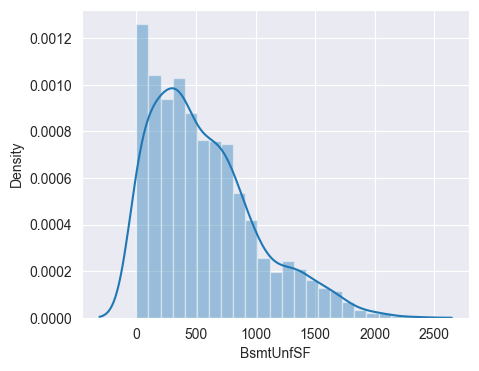

In [334]:
skewness = train_data[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[skewness>0.5]
skew_features = skewness.index
#skewness

print(stats.kurtosis(train_data['BsmtUnfSF'], fisher=False))
print(stats.skew(train_data['BsmtUnfSF']))

plt.figure(figsize=(5, 4))
sns.distplot(train_data['BsmtUnfSF'])

In [335]:
for col in skew_features:
    lam = stats.boxcox_normmax(train_data[col] + 1)    #+1是为了保证输入大于零
    train_data[col] = boxcox1p(train_data[col], lam)
    test_data[col] = boxcox1p(test_data[col], lam)

#print(stats.kurtosis(train_data['MiscVal'], fisher=False))
#print(stats.skew(train_data['MiscVal']))

### 9、构建新的特征

BltRemodDiff
0      761
1      214
30      21
2       14
9       14
      ... 
100      1
110      1
111      1
64       1
84       1
Name: count, Length: 109, dtype: int64
feats2del:{'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'IsRemod', 'BltRemodDiff', 'Utilities', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}
feats2del:{'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'IsRemod', 'BltRemodDiff', 'Utilities', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}


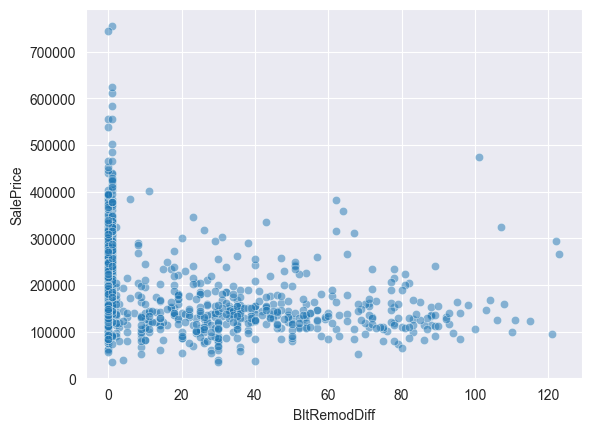

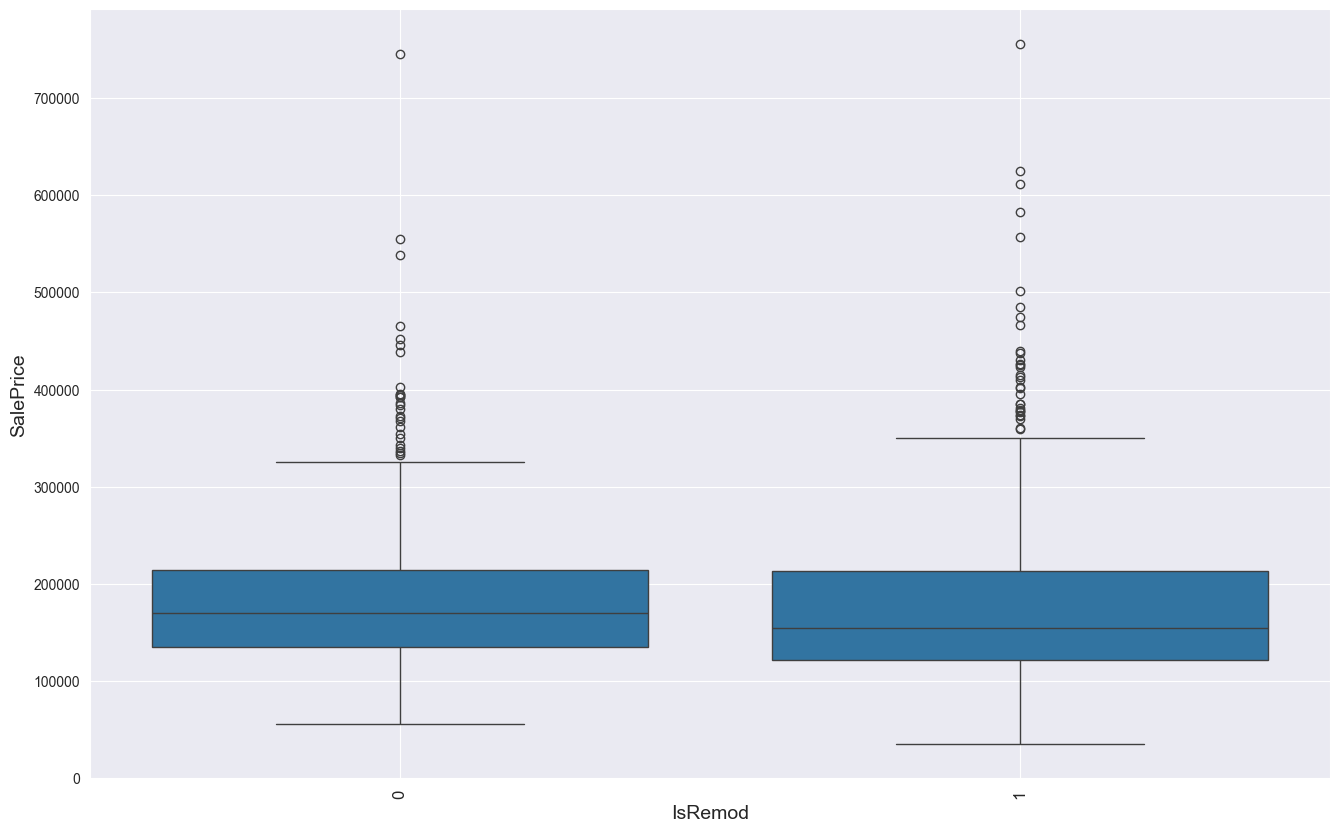

In [348]:
train_data['IsRemod'] = 1 
train_data['IsRemod'].loc[train_data['YearBuilt']==train_data['YearRemodAdd']] = 0  #是否翻新(翻新：1， 未翻新：0)
train_data['BltRemodDiff'] = train_data['YearRemodAdd'] - train_data['YearBuilt']  #翻新与建造的时间差（年）
print(train_data['BltRemodDiff'].value_counts(dropna=False))
sns.scatterplot(x='BltRemodDiff', y='SalePrice', data=train_data, alpha=0.5)

plt.figure(figsize=(16, 10))
sns.boxplot(x='IsRemod', y='SalePrice', data=train_data)
plt.xlabel('IsRemod', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(True)

# 这两个特征和房价关系不明显，不添加
add_feats2del('IsRemod')
add_feats2del('BltRemodDiff')

feats2del:{'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'IsRemod', 'BltRemodDiff', 'Utilities', 'BsmtUnfRatio', 'Id', 'YrSold', 'YearBuilt', 'GarageArea'}


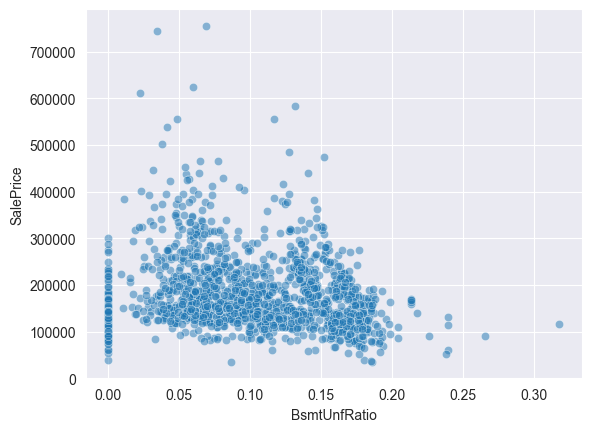

In [349]:
train_data['BsmtUnfRatio'] = 0
train_data['BsmtUnfRatio'].loc[train_data['TotalBsmtSF']!=0] = train_data['BsmtUnfSF'] / train_data['TotalBsmtSF']  #Basement未完成占总面积的比例

sns.scatterplot(x='BsmtUnfRatio', y='SalePrice', data=train_data, alpha=0.5)

# 这个特征和房价关系不明显，不添加
add_feats2del('BsmtUnfRatio')

<Axes: xlabel='TotalSF', ylabel='SalePrice'>

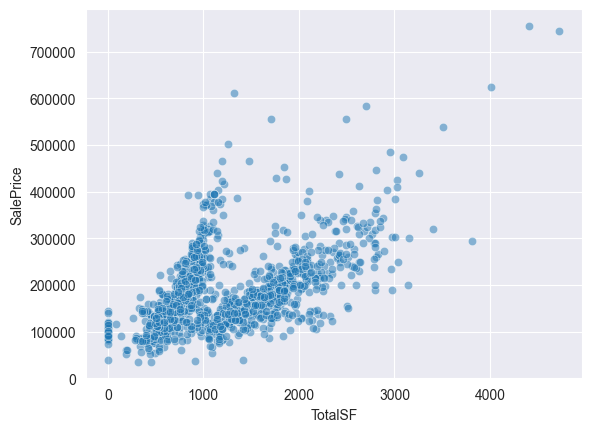

In [350]:
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']  #总面积

sns.scatterplot(x='TotalSF', y='SalePrice', data=train_data, alpha=0.5)

In [351]:
#对测试集做同样的处理
test_data['IsRemod'] = 1 
test_data['IsRemod'].loc[test_data['YearBuilt']==test_data['YearRemodAdd']] = 0  #是否翻新(翻新：1， 未翻新：0)
test_data['BltRemodDiff'] = test_data['YearRemodAdd'] - test_data['YearBuilt']  #翻新与建造的时间差（年）
test_data['BsmtUnfRatio'] = 0
test_data['BsmtUnfRatio'].loc[test_data['TotalBsmtSF']!=0] = test_data['BsmtUnfSF'] / test_data['TotalBsmtSF']  #Basement未完成占总面积的比例
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']  #总面积

### 10、删除无效特征

In [352]:
for feat in feats2del:
    if feat in train_data:
        train_data.drop(feats2del, axis=1, inplace=True)

    if feat in test_data:
        test_data.drop(feats2del, axis=1, inplace=True)  

print(train_data.shape)
print(test_data.shape)

(1454, 74)
(1459, 73)


**检查是否还存在缺失值**

In [353]:
train_data.isnull().sum().any()

False

In [354]:
test_data.isnull().sum().any()

False

### 11、处理其余的类别特征

**策略二：对不存在顺序关系的类别特征采用独热编码**

In [355]:
print('The shape of training data:', train_data.shape)
print('The shape of testing data:', test_data.shape)

The shape of training data: (1454, 74)
The shape of testing data: (1459, 73)


In [356]:
dummy_features = list(set(cate_features).difference(set(le_features)))
dummy_features

['MSZoning',
 'LotConfig',
 'Condition1',
 'MiscFeature',
 'Condition2',
 'BldgType',
 'MasVnrType',
 'SaleCondition',
 'Electrical',
 'RoofStyle',
 'SaleType',
 'GarageType',
 'Heating',
 'Neighborhood']

In [357]:
all_data = pd.concat((train_data.drop('SalePrice', axis=1), test_data)).reset_index(drop=True)
all_data.shape

(2913, 73)

In [358]:
all_data = pd.get_dummies(all_data, drop_first=True)  #注意独热编码生成的时候要去掉一个维度，保证剩下的变量都是相互独立的
all_data.shape

(2913, 150)

### 12、还原训练集与测试集并保存

In [359]:
trainset = all_data[:train_data.shape[0]]
y = train_data['SalePrice']
trainset['SalePrice'] = y.values
testset = all_data[train_data.shape[0]:]
print('The shape of training data:', trainset.shape)
print('The shape of testing data:', testset.shape)

The shape of training data: (1454, 151)
The shape of testing data: (1459, 150)


In [1]:
trainset.to_csv(os.path.join('./data', 'train_data.csv'), index=False)
testset.to_csv(os.path.join('./data', 'test_data.csv'), index=False)

NameError: name 'trainset' is not defined

In [361]:
trainset.isnull().sum().any()

False

In [362]:
train_data.isnull().sum().any()

False